# Generative Adversarial Network (GAN)
Since GANs were introduced in 2014 by Google Researcher Ian Goodfellow, the tech has been widely adopted in image generation and transfer. After some early wiry failures, GANs have made huge breakthroughs and can now produce highly convincing fake images of animals, landscapes, human faces, etc. Researchers know what GANs can do, however a lack of transparency in their inner workings means GAN improvement is still achieved mainly through trial-and-error. This allows only limited control over the synthesized images

-------------
## Packages
Let's first import the necessary packages,

In [22]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import torchvision.datasets as dset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
%matplotlib inline

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [23]:
# use GPU if its available, else use cpu for local development
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Type of device currently in use:",device)

Type of device currently in use: cuda


-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. latent size
2. hidden size
3. input image size
4. numbper of epoches
5. batch size
6. out put directory

In [92]:
learning_rate = 0.0001
latent_size = 100
hidden_size = 128
input_img_size = 64
epochs = 5
batch_sizing =128
mini_batch_size = 100
PATH = "/home/mmvc/mmvc-ad-teachnas/ML_2020_Spring/data";

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [67]:
if not os.path.exists(PATH):
    os.makedirs(PATH)

-----
##  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use transforms.CenterCrop(160) 
3. Use transforms.Scale(64) = this is deprecated so instead  I used transforms.Resize


In [68]:
transformer = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [93]:

dataset = torchvision.datasets.ImageFolder(
    root=PATH, 
    transform=transformer
     )
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=mini_batch_size, 
    shuffle=True, 
    num_workers=4
    )




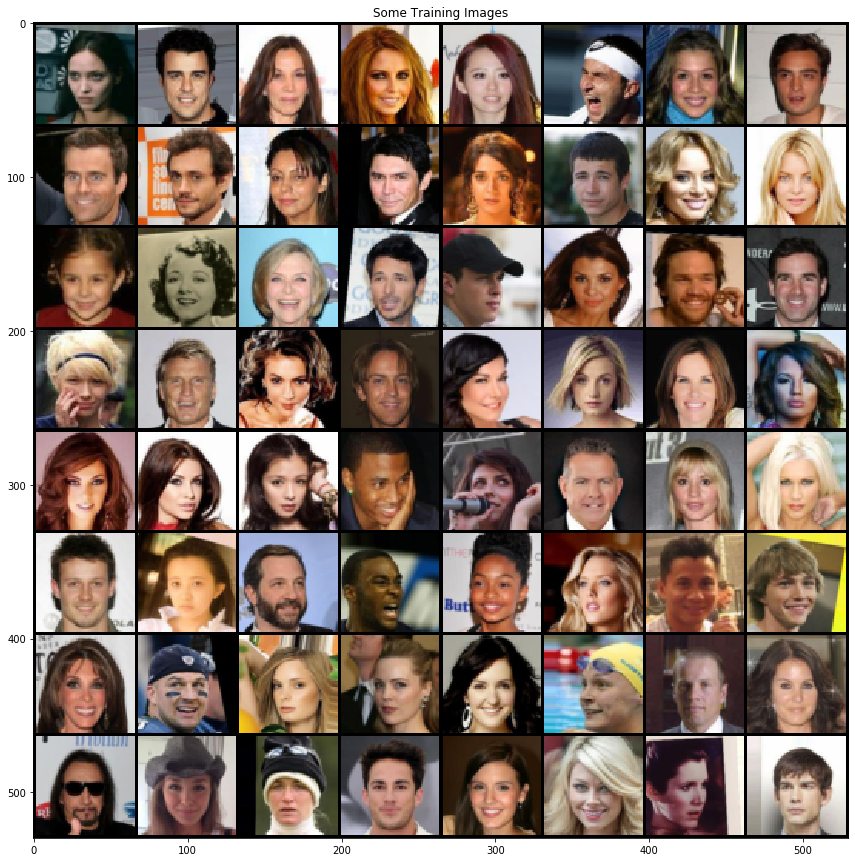

In [94]:
data_iter = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.title("Some Training Images")
plt.imshow(np.transpose(vutils.make_grid(data_iter[0][:64], padding=2, normalize=True),(1,2,0)))
plt.show()

-----
##  Network
Next, we are going to design our GAN
We use the pytorch function nn.Sequential() to stack several layers as well as activation functions
### First, we need to create our discriminator
1. We need one input layer, one hidden layers and one out put layer. All of them are defined using nn.Linear() with proper input dim and out dim


2. We adopt nn.LeakyReLU(0.2) as activation layer for the input and hidden layer. 


3. We use nn.Sigmoid() activation function for the output layer

### Next, we are going to define our generator 
1. We need one input layer, one hidden layers and one out put layer. All of them are defined using nn.Linear() with proper input dim and out dim


2. We adopt nn.ReLU() as activation layer for the input and hidden layer. 


3. We use nn.Tanh() activation function for the output layer


#### Please First construct the generator module as follow:
1.	The input of the first linear layer is the latent vector size, output of the first layer is 256
2.	Then followed by a ReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the ReLU layer
5.	The input of the third layer is the 512 and output channel is 1024
6.	Followed by the ReLU layer
7.	The input of the fourth layer is the 1024 and output channel is 1024
8.	Followed by the ReLU layer
9.	The input of the final layer is the 1024 and output channel is the image size.
10.	The Tanh is activation function.

#### Please First construct the discriminator module as follow:
1.	The input of the first linear layer is the image size, output of the first layer is 256
2.	Then followed by a LeakyReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the leakyReLU layer
5.	The input of the third layer is the 512 and output channel is 512
6.	Followed by the leakyReLU layer
7.	The input of the final layer is the 512 and output channel is 1
8.	The sigmoid is activation function.


In [133]:
# Discriminator

class Discriminator(nn.Module):
  def __init__(self,image_size=64):
    super(Discriminator,self).__init__()

    self.layers = nn.Sequential(
        nn.Linear(image_size,256),
        nn.LeakyReLU(0.2,inplace=True),         
        nn.Linear(256,512),
        nn.LeakyReLU(0.2,inplace=True),         
        nn.Linear(512,512),
        nn.LeakyReLU(0.2,inplace=True),         
        nn.Linear(512,1),         
        nn.Sigmoid()
    )       

  def forward(self,x):
    result = self.layers(x)
    return result




# Generator 
class Generator(nn.Module):
  def __init__(self,latent_vector = 100,image_size=64):
    super(Generator, self).__init__()

    self.layers = nn.Sequential( 
        nn.Linear(latent_vector,256),
        nn.ReLU(True),         
        nn.Linear(256,512),
        nn.ReLU(True),           
        nn.Linear(512,1024),
        nn.ReLU(True), 
        nn.Linear(1024,1024),
        nn.ReLU(True),  
        nn.Linear(1024,image_size),
        nn.ReLU(True),            
        nn.Tanh()
    )

  def forward(self,x):
    result = self.layers(x)
    return result








### Next, we send the network to the target device

In [134]:
# hidden_size = 128;
# input_img_size = 64;
discriminator = Discriminator().to(device)
generator = Generator().to(device)
print("-----------Discriminator---------------")
print(discriminator)
print("-----------Generator---------------")
print(generator)



-----------Discriminator---------------
Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
-----------Generator---------------
Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=1024, out_features=64, bias=Tr

### Finally, We set the Binary cross entropy loss and optimizer with proper netwrok parameters and learning rates

In [58]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


# Noise to check the progress of
fixed_noise = Variable(torch.randn(64, 100)).to(device)

-----
##  Training
Then, we are going to train our Network
### We first starting with two helper function
1. We frist implement the denorm function using clamp() api from pytorch please refer https://pytorch.org/docs/stable/torch.html?highlight=clamp#torch.clamp
2. We define a function that reset all the gradient of the optimziers.

In [59]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

### Start training
1. we first store the total steps which is equal to the length of data_loader
2. for each epoch
    <br/> a. for each element index and element in the data loader
        i. we reshape the input data to (batch_size，-1) and send to the proper device
        ii. then we create the real and fake labels which are later used as input for the BCE loss using torch.ones(batch_size, 1).to(device) and torch.zeros(batch_size, 1).to(device)
        iii. then we train the descriminator
            A. feedforward and store the predictions of discriminator
            B. compute BCE_Loss using real images and store the loss
            C. random init a latent code z
            D. feedforward and store the predictions of generator
            E. feed the predictions to the descriminator and sotre the prediction
            F. compute BCELoss using fake images and store the loss
            G. perofrm the backprop using losses after that reset the gradient of optimzier.
        iv. then we train the generator
            A. using torch.randn(batch_size, latent_size).to(device) to init a z
            B. feedforward and store the predictions of generator
            C. feed the predictions to the descriminator and sotre the prediction
            D. compute BCE_Loss using real images and store the loss
            F. perofrm the backprop using losses after that reset the gradient of optimzier.
        v. some centain period, we prient the log with proper info
    <br/> b. we store all real image with shape (images.size(0), 1, 28, 28) inoder for the further comparision only once
    <br/> c. we save the fake image with image shape (images.size(0), 1, 28, 28) and denorm() function 
3. Save the model checkpoints using torch.save()


In [ ]:
fixed_noise = torch.randn(batch_size,latent_size).to(device) 


fakeimages = []
G_losses = []
D_losses = []
counter = 0

total_step = len(dataloader)

real_label = 1
fake_label = 0

for epoch in range(epochs):

    for i, data in enumerate(dataloader, 0):
        
        reset_grad()
#----------------Discriminator Training---------------


        image = data[0].to(device)
        batch_size = image.size(0)

        output = discriminator(image).view(-1)
        label = torch.full((output.size(0),), real_label, device=device)

        d_real_loss = criterion(output, label)
        reals = output
        
        
        
        train_noise = torch.randn(batch_size, latent_size,1,1, device = device)
        fake_images = generator(fixed_noise)
        output = discriminator(fake_images).view(-1)
        label = torch.full((output.size(0),), fake_label, device=device)
        d_fake_loss = criterion(output,label)
        d_loss = d_real_loss + d_fake_loss
        D_losses.append(d_loss.item())
        d_loss.backward()
        d_optimizer.step()      
        
#--------------Generator Training -------------------

        output = discriminator(fake_images).view(-1)
        label = torch.full((output.size(0),), real_label, device=device)
        g_loss = criterion(output, label)
        g_loss.backward()
        g_optimizer.step()
        G_losses.append(g_loss.item())
        
        if (i) % 100 == 0:
            print(f'Step {counter+1}, epoch {epoch+1} Generator loss {g_loss.item()}, Discriminator loss {d_loss.item()}') 
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
                fakeimages.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        counter+=1
        
        







In [156]:
torch.save(generator.state_dict(), 'generator.pkl')
torch.save(discriminator.state_dict(), 'discriminator.pkl')

# Graphing the loss of the Generator and the Discriminator

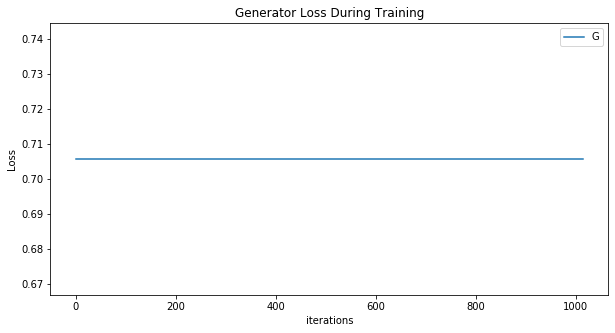

In [157]:
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

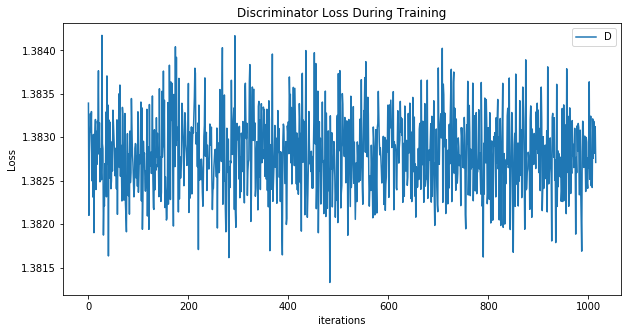

In [155]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()




In [ ]:
# A fake image generated

<function matplotlib.pyplot.show(*args, **kw)>

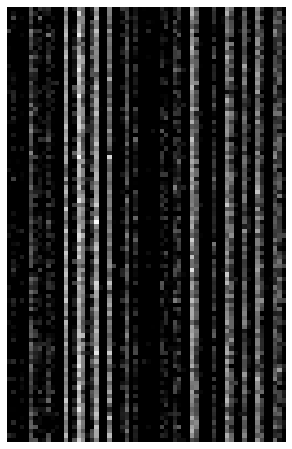

In [158]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(fakeimages[-1],(1,2,0)))
plt.show

# References
- https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
- Yi Fang Slides

# Report

In this project, I set out to replicate the framework proposed by Ian Good Fellow named General Adverserial Networks. Namely, I imitate the structure of an Adversial Network by creating a Discriminator Class and a Generator Class as depicted in the picture below:

<img src="https://miro.medium.com/max/2752/1*uTFUp2PzqfVu0WMOE-hilA.png">

The Generator is in charge of creating new images  and the Discriminator is in charge of classifying whether or not the images are real or fake. Both the Generator and the Discriminator are trained in a parallel manner, the discriminator learning from the real images and the Generator learning from the feedback received by the Discriminator. By following this structure, we can create a set of fake images that, after suffoicient training, look like the real images. Due to a lack of computing power, we werent able to produce impressive results in this GAN implementation. However, we were able to decrease the loss of both the geenerator and the discriminator overtime, which points to the fact that with sufficient training and maybe a rechoosing of our hyperparameters, this GAN would have been as effective as intended. 

The chosen hyperparamters for this implementation are the following:
learning_rate = 0.0001
latent_size = 100
hidden_size = 128
input_img_size = 64
epochs = 5
batch_sizing =128
mini_batch_size = 100


Major changes from initial specifications:
- I changed my discriminator optimizer from SGD to adam as using the adam SGD fixed a cuda out of memory issue I had.

# Major improvements
First and foremost, I would probably use a more powerful server to run this algorithm in and I would increase the batch size in order to train both the discriminator and the generator more potently. However, I have saved both the discriminator and the genrator using the torch.save() command in order to improve training in a future reiteration of this project.

